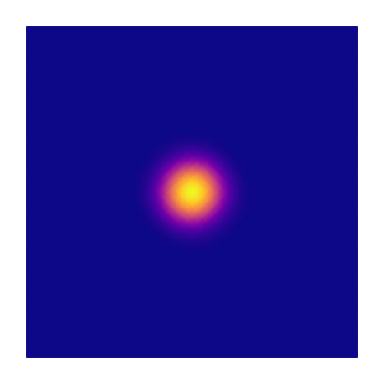

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


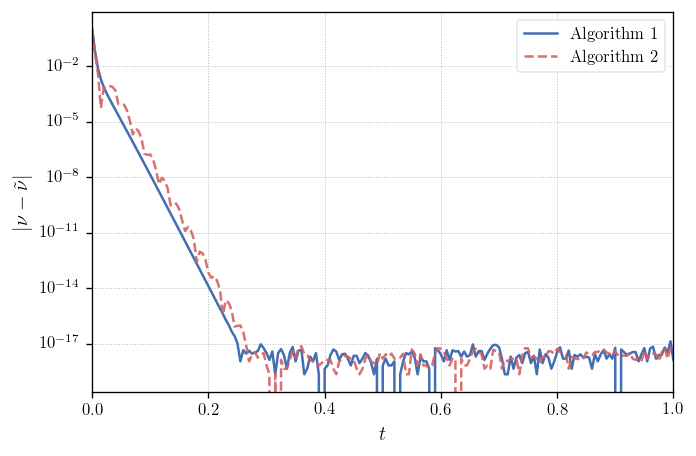

In [20]:
# Example 1
# 2D Allen-Cahn equation
# ∂ₜu - νΔu + f(u) = 0
# Continuous data assimilation algorithm
# ∂ₜv - νΔv + f(v) = μ(u - v)
# 
# Implicit Euler Method: 
# #
import importlib.util
if importlib.util.find_spec("petsc4py") is not None:
    import dolfinx
    if not dolfinx.has_petsc:
        print("This program requires DOLFINx to be compiled with PETSc enabled.")
        exit(0)
else:
    print("This program requires petsc4py.")
    exit(0)

try:
    from petsc4py import PETSc
    import dolfinx
    if not dolfinx.has_petsc:
        print("This program requires DOLFINx to be compiled with PETSc enabled.")
        exit(0)
except ModuleNotFoundError:
    print("This program requires petsc4py.")
    exit(0)

from mpi4py import MPI
from numpy import sqrt, linspace, isclose, where, sin, pi, ones, zeros, zeros_like, ones_like
from dolfinx.mesh import create_unit_square, exterior_facet_indices, CellType
from dolfinx.fem import (
    functionspace, Function, assemble_scalar,
    form, locate_dofs_topological, dirichletbc
)
from dolfinx.fem.petsc import (
    assemble_matrix, assemble_vector, create_matrix, create_vector, apply_lifting, set_bc
)
from ufl import TestFunction, TrialFunction, inner, grad, dx
import matplotlib.pyplot as plt

# --- Parameters ---
Nx, Ny = 64, 64                # Spatial step
T   = 1.0                      # Total time
ν   = 1e-3                     # Diffusion coefficient
M   = 200                      # Number of time steps
t   = linspace(0, T, M + 1)    # Time points
Δt  = (T / M)
TOL = 1e-8                     # Tolerance

def f(u):
    return u * (u**2 - 1)

def df(u):
    return 3 * u**2 - 1

def L2(u):
    return sqrt(assemble_scalar(form(inner(u, u) * dx)))

# --- Data assimialtion & nudging parameter
μ = 200.0
χ = zeros(M + 1)
ζ = zeros(M + 1)

χ[0] = 1.0
ζ[0] = 1.0

# --- Dicrichlet boundary condition ---
def walls_boundary(x):
    return (
        isclose(x[0], 0.0) | isclose(x[0], 1.0) |
        isclose(x[1], 0.0) | isclose(x[1], 1.0)
    )

def initial_condition(x):
    cx, cy, r = 0.5, 0.5, 0.05
    condition = (x[0] - cx)**2 + (x[1] - cy)**2 <= r**2
    return where(condition, 1.0, 0.0)

# --- Mesh ---
domain = create_unit_square(MPI.COMM_WORLD, Nx, Ny, CellType.triangle)
domain.topology.create_connectivity(domain.topology.dim - 1, domain.topology.dim)

# --- Finite element space
V = functionspace(domain, ("Lagrange", 1))

walls = Function(V)
walls.interpolate(lambda x: zeros_like(x[0]))
walls_facets = exterior_facet_indices(domain.topology)
walls_dofs   = locate_dofs_topological(V, domain.topology.dim - 1, walls_facets)
bc_walls     = dirichletbc(walls, walls_dofs)
bcs = [bc_walls]

# --- Variational form ---
w = TestFunction(V)
δu = TrialFunction(V)
δv = TrialFunction(V)

# --- Reference solution ---
u = zeros((M + 1, len(V.tabulate_dof_coordinates()[:, 0])))
uh = Function(V)
u_ = Function(V)
uh.interpolate(initial_condition)
u[0] = uh.x.array[:]

for j in range(M):
    u_.x.array[:] = u[j]
    du = Function(V)
    while True:
        # Variational form
        F = form((
            inner(uh - u_, w) * dx
            + Δt * ν * inner(grad(uh), grad(w)) * dx
            + Δt * inner(f(uh), w) * dx
        ))
        J = form((
            inner(δu, w) * dx
            + Δt * ν * inner(grad(δu), grad(w)) * dx
            + Δt * inner(df(uh) * δu, w) * dx
        ))
        # Assemble Jacobian and residual
        A = create_matrix(J)
        b = create_vector(F)

        with b.localForm() as loc_b:
            loc_b.set(0)
        A.zeroEntries()
        assemble_matrix(A, J, bcs = bcs)
        A.assemble()
        assemble_vector(b, F)
        b.ghostUpdate(addv = PETSc.InsertMode.ADD, mode = PETSc.ScatterMode.REVERSE)
        b.scale(-1)
        
        # Compute BC
        apply_lifting(b, [J], [bcs], x0 = [uh.x.petsc_vec], alpha = 1)
        # Set
        set_bc(b, bcs, uh.x.petsc_vec, 1.0)
        b.ghostUpdate(addv = PETSc.InsertMode.INSERT_VALUES, mode = PETSc.ScatterMode.FORWARD)
        
        solver = PETSc.KSP().create(domain.comm)
        solver.setOperators(A)
        solver.setType("preonly")
        solver.getPC().setType("lu")
        solver.getPC().setFactorSolverType("mumps")
        solver.setFromOptions()

        # Solver linear  problem
        solver.solve(b, du.x.petsc_vec)
        du.x.scatter_forward()

        # Update solution
        uh.x.array[:] += du.x.array
        if du.x.petsc_vec.norm(0) < TOL:
            break
    
    # Update reference solution
    u[j + 1] = uh.x.array[:]
        
if domain.comm.rank == 0:
    coods = domain.geometry.x[:, :2]

    # Plot solution t = T
    plt.figure(figsize = (4, 4))
    plt.tripcolor(coods[:, 0], coods[:, 1], u[M], shading = "gouraud", cmap = "plasma")
    plt.axis("off")
    plt.grid(True, which = "both", ls = "--")
    plt.tight_layout()
    plt.show()

# --- Data assimilation solution ---
vh = Function(V)
v_ = Function(V)

# --- Algorithm 1 ---
Error1 = zeros(M + 1)
Error1[0] = abs(ν - χ[0])

for j in range(M):
    # Update parameter
    v_.x.array[:] = vh.x.array
    ξ = χ[j]

    dv = Function(V)
    _u = Function(V)
    _u.x.array[:] = u[j + 1]
    while True:
        # Variational form
        F = form((
            inner(vh - v_, w) * dx
            + Δt * ξ * inner(grad(vh), grad(w)) * dx
            + Δt * inner(f(vh), w) * dx
            + Δt * μ * inner(vh - _u, w) * dx
        ))
        J = form((
            inner(δv, w) * dx
            + Δt * ξ * inner(grad(δv), grad(w)) * dx
            + Δt * inner(df(vh) * δv, w) * dx
            + Δt * μ * inner(δv, w) * dx
        ))
        # Assemble Jacobian and residual
        A = create_matrix(J)
        b = create_vector(F)

        with b.localForm() as loc_b:
            loc_b.set(0)
        A.zeroEntries()
        assemble_matrix(A, J, bcs = bcs)
        A.assemble()
        assemble_vector(b, F)
        b.ghostUpdate(addv = PETSc.InsertMode.ADD, mode = PETSc.ScatterMode.REVERSE)
        b.scale(-1)
        
        # Compute BC
        apply_lifting(b, [J], [bcs], x0 = [vh.x.petsc_vec], alpha = 1)
        # Set
        set_bc(b, bcs, vh.x.petsc_vec, 1.0)
        b.ghostUpdate(addv = PETSc.InsertMode.INSERT_VALUES, mode = PETSc.ScatterMode.FORWARD)
        
        solver = PETSc.KSP().create(domain.comm)
        solver.setOperators(A)
        solver.setType("preonly")
        solver.getPC().setType("lu")
        solver.getPC().setFactorSolverType("mumps")
        solver.setFromOptions()

        # Solver linear  problem
        solver.solve(b, dv.x.petsc_vec)
        dv.x.scatter_forward()

        # Update solution
        vh.x.array[:] += dv.x.array
        if dv.x.petsc_vec.norm(0) < TOL:
            break
    
    # Recovery parameter
    numerator = Function(V)
    numerator.x.array[:] = _u.x.array - u[j]
    χ[j + 1] = ξ * L2(numerator + Δt * f(_u)) / L2((vh - v_) + Δt * f(vh) + Δt * μ * (vh - _u))

    Error1[j + 1] = abs(ν - χ[j + 1])

# --- Algorithm 2 ---
Error2 = zeros(M + 1)
Error2[0] = abs(ν - ζ[0])

for j in range(M):
    # Update parameter
    v_.x.array[:] = vh.x.array
    ξ = ζ[j]

    dv = Function(V)
    _u = Function(V)
    _u.x.array[:] = u[j + 1]
    while True:
        # Variational form
        F = form((
            inner(vh - v_, w) * dx
            + Δt * ξ * inner(grad(vh), grad(w)) * dx
            + Δt * inner(f(vh), w) * dx
            + Δt * μ * inner(vh - _u, w) * dx
        ))
        J = form((
            inner(δv, w) * dx
            + Δt * ξ * inner(grad(δv), grad(w)) * dx
            + Δt * inner(df(vh) * δv, w) * dx
            + Δt * μ * inner(δv, w) * dx
        ))
        # Assemble Jacobian and residual
        A = create_matrix(J)
        b = create_vector(F)

        with b.localForm() as loc_b:
            loc_b.set(0)
        A.zeroEntries()
        assemble_matrix(A, J, bcs = bcs)
        A.assemble()
        assemble_vector(b, F)
        b.ghostUpdate(addv = PETSc.InsertMode.ADD, mode = PETSc.ScatterMode.REVERSE)
        b.scale(-1)
        
        # Compute BC
        apply_lifting(b, [J], [bcs], x0 = [vh.x.petsc_vec], alpha = 1)
        # Set
        set_bc(b, bcs, vh.x.petsc_vec, 1.0)
        b.ghostUpdate(addv = PETSc.InsertMode.INSERT_VALUES, mode = PETSc.ScatterMode.FORWARD)
        
        solver = PETSc.KSP().create(domain.comm)
        solver.setOperators(A)
        solver.setType("preonly")
        solver.getPC().setType("lu")
        solver.getPC().setFactorSolverType("mumps")
        solver.setFromOptions()

        # Solver linear  problem
        solver.solve(b, dv.x.petsc_vec)
        dv.x.scatter_forward()

        # Update solution
        vh.x.array[:] += dv.x.array
        if dv.x.petsc_vec.norm(0) < TOL:
            break
    
    # Recovery parameter
    _u_ = Function(V)
    _u_.x.array[:] = u[j]
    ζ[j + 1] = ξ * L2((_u - _u_) + 0.5 * Δt * (f(_u) + f(_u_))) /\
             L2((vh - v_) + 0.5 * Δt * (f(vh) + f(v_)) + 0.5 * Δt * μ * ((vh - _u) + (v_ - _u_)))

    Error2[j + 1] = abs(ν - ζ[j + 1])

if domain.comm.rank == 0:
    # Set Latex font with better parameters
    plt.rc("text"  , usetex    = True)
    plt.rc("font"  , family    = "serif", size = 12)
    plt.rc("axes"  , titlesize = 12)        # fontsize of the axes title
    plt.rc("axes"  , labelsize = 12)        # fontsize of the x and y labels
    plt.rc("xtick" , labelsize = 10)        # fontsize of the tick labels
    plt.rc("ytick" , labelsize = 10)        # fontsize of the tick labels
    plt.rc("legend", fontsize  = 10)        # legend fontsize

    # Create figure with better proportions
    fig, ax = plt.subplots(figsize = (6, 4), dpi = 120)
    
    # colors = ['#4C72B0', '#DD8452']  # Blue         & Orange
    # colors = ['#2E5EAA', '#D56062']  # Deep Blue    & Coral
    # colors = ['#006BA4', '#FF800E']  # Tableau Blue & Orange
    # colors = ['#1F77B4', '#FF7F0E']  # Matplotlib default

    # Plot with explicit styling
    line1, = ax.plot(t, Error1, color = "#2E5EAA", linestyle = "-" ,
                     linewidth = 1.5, alpha = 0.9,
                     label = r"Algorithm 1")
    line2, = ax.plot(t, Error2, color = "#D56062", linestyle = "--",
                     linewidth = 1.5, alpha = 0.9,
                     label = r"Algorithm 2")
    
    # Set scales and labels
    ax.set_yscale("log")
    ax.set_xlim(0, 1)
    ax.set_xlabel(r"$t$", labelpad = 5)
    ax.set_ylabel(r"$|\nu - \tilde{\nu}|$", labelpad = 5)
    
    # Improved legend
    ax.legend(loc = "best", frameon = True, framealpha = 0.95,
              edgecolor = "0.9", facecolor = "white")
    
    # Grid and layout improvements
    ax.grid(True, which = "both", linestyle = ":", linewidth = 0.6, alpha = 0.5, color = "gray")
    ax.set_axisbelow(True)              # grid behind plot elements
    
    # Adjust layout and save/show
    fig.tight_layout(pad = 1.2)         # extra padding around plot
    
    # For saving
    plt.savefig("./image/Example1_Tol_time.eps", bbox_inches = "tight", dpi = 300)
    plt.savefig("./image/Example1_Tol_time.png", bbox_inches = "tight", dpi = 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


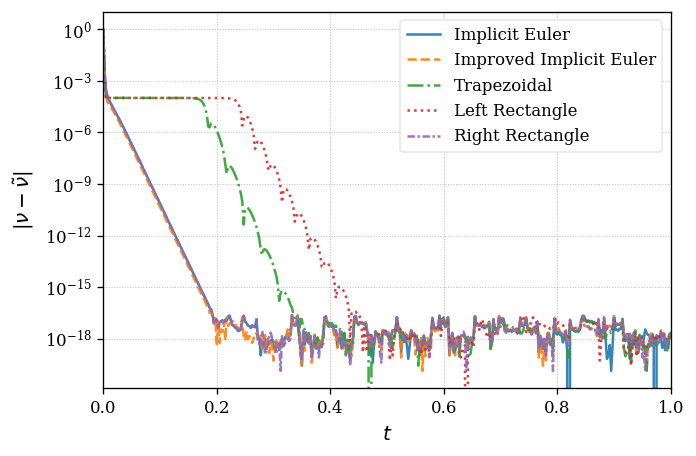

In [ ]:
# Example 1
# 2D Allen-Cahn equation
# ∂ₜu - νΔu + f(u) = 0
# Continuous data assimilation algorithm
# ∂ₜv - νΔv + f(v) = μ(u - v)
# 
# #
import importlib.util
if importlib.util.find_spec("petsc4py") is not None:
    import dolfinx
    if not dolfinx.has_petsc:
        print("This program requires DOLFINx to be compiled with PETSc enabled.")
        exit(0)
else:
    print("This program requires petsc4py.")
    exit(0)

try:
    from petsc4py import PETSc
    import dolfinx
    if not dolfinx.has_petsc:
        print("This program requires DOLFINx to be compiled with PETSc enabled.")
        exit(0)
except ModuleNotFoundError:
    print("This program requires petsc4py.")
    exit(0)

from mpi4py import MPI
from numpy import sqrt, linspace, isclose, where, zeros, zeros_like
from dolfinx.mesh import create_unit_square, exterior_facet_indices, CellType
from dolfinx.fem import (
    functionspace, Function, assemble_scalar, Constant,
    form, locate_dofs_topological, dirichletbc
)
from dolfinx.fem.petsc import (
    assemble_matrix, assemble_vector, create_matrix, create_vector, apply_lifting, set_bc
)
from ufl import TestFunction, TrialFunction, inner, grad, dx
import matplotlib.pyplot as plt

# --- Parameters ---
Nx, Ny = 16, 16                # Spatial step
T   = 1.0                      # Total time
ν   = 1e-4                     # Diffusion coefficient
M   = 400                     # Number of time steps
t   = linspace(0, T, M + 1)    # Time points
Δt  = (T / M)
TOL = 1e-8                     # Tolerance

def f(u):
    return u * (u**2 - 1)

def df(u):
    return 3 * u**2 - 1

def L2(u):
    return sqrt(assemble_scalar(form(inner(u, u) * dx)))

# --- Dicrichlet boundary condition ---
def walls_boundary(x):
    return (
        isclose(x[0], 0.0) | isclose(x[0], 1.0) |
        isclose(x[1], 0.0) | isclose(x[1], 1.0)
    )

def initial_condition(x):
    cx, cy, r = 0.5, 0.5, 0.05
    condition = (x[0] - cx)**2 + (x[1] - cy)**2 <= r**2
    return where(condition, 1.0, 0.0)

# --- Mesh ---
domain = create_unit_square(MPI.COMM_WORLD, Nx, Ny, CellType.triangle)
domain.topology.create_connectivity(domain.topology.dim - 1, domain.topology.dim)

# --- Finite element space
V = functionspace(domain, ("Lagrange", 1))

walls = Function(V)
walls.interpolate(lambda x: zeros_like(x[0]))
walls_facets = exterior_facet_indices(domain.topology)
walls_dofs   = locate_dofs_topological(V, domain.topology.dim - 1, walls_facets)
bc_walls     = dirichletbc(walls, walls_dofs)
bcs = [bc_walls]

# --- Variational form ---
w  = TestFunction(V)
δu = TrialFunction(V)
δv = TrialFunction(V)

# --- Reference solution ---
u = zeros((M + 1, len(V.tabulate_dof_coordinates()[:, 0])))
uh = Function(V)
u_ = Function(V)
uh.interpolate(initial_condition)
u[0] = uh.x.array[:]

# --- Time loop ---
for j in range(M):
    u_.x.array[:] = u[j]
    du = Function(V)
    while True:
        # Variational form
        F = form((
            inner(uh - u_, w) * dx
            + Δt * ν * inner(grad(uh), grad(w)) * dx
            + Δt * inner(f(uh), w) * dx
        ))
        J = form((
            inner(δu, w) * dx
            + Δt * ν * inner(grad(δu), grad(w)) * dx
            + Δt * inner(df(uh) * δu, w) * dx
        ))
        # Assemble Jacobian and residual
        A = create_matrix(J)
        b = create_vector(F)

        with b.localForm() as loc_b:
            loc_b.set(0)
        A.zeroEntries()
        assemble_matrix(A, J, bcs = bcs)
        A.assemble()
        assemble_vector(b, F)
        b.ghostUpdate(addv = PETSc.InsertMode.ADD, mode = PETSc.ScatterMode.REVERSE)
        b.scale(-1)
        
        # Compute BC
        apply_lifting(b, [J], [bcs], x0 = [uh.x.petsc_vec], alpha = 1)
        # Set
        set_bc(b, bcs, uh.x.petsc_vec, 1.0)
        b.ghostUpdate(addv = PETSc.InsertMode.INSERT_VALUES, mode = PETSc.ScatterMode.FORWARD)
        
        solver = PETSc.KSP().create(domain.comm)
        solver.setOperators(A)
        solver.setType("preonly")
        solver.getPC().setType("lu")
        solver.getPC().setFactorSolverType("mumps")
        solver.setFromOptions()

        # Solver linear  problem
        solver.solve(b, du.x.petsc_vec)
        du.x.scatter_forward()

        # Update solution
        uh.x.array[:] += du.x.array
        if du.x.petsc_vec.norm(0) < TOL:
            break
    
    # Update reference solution
    u[j + 1] = uh.x.array[:]

# --- Data assimialtion parameter
μ = 200.0
L = 5
χ = zeros((M + 1, L))
Error = zeros((M + 1, L))

def algorithm(ξ, uh, up, vh, vp, l):
    if l == 0:
        # Implicit Euler Method
        den = L2((uh - up) / Δt + f(uh))
        num = L2((vh - vp) / Δt + f(vh) + μ * (vh - uh))
        return ξ * den / num
    elif l == 1:
        # Improved Implicit Euler Method
        den = L2((uh - up) / Δt + f(vh))
        num = L2((vh - vp) / Δt + f(vh) + μ * (vh - uh))
        return ξ * den / num
    elif l == 2:
        # Trapezoidal Method
        den = L2((uh - up) + 0.5 * Δt * (f(uh) + f(up)))
        num = L2((vh - vp) + 0.5 * Δt * (f(vh) + f(vp)) + 0.5 * Δt * μ * ((vh - uh) + (vp - up)))
        return ξ * den / num
    elif l == 3:
        # Left rectangle Method
        den = L2((uh - up) + Δt * f(up))
        num = L2((vh - vp) + Δt * f(vp) + Δt * μ * (vp - up))
        return ξ * den / num
    elif l == 4:
        # Right rectangle Method
        den = L2((uh - up) + Δt * f(uh))
        num = L2((vh - vp) + Δt * f(vh) + Δt * μ * (vh - uh))
        return ξ * den / num

for l in range(L):
    χ[0, l]     = 1.0
    Error[0, l] = abs(ν - χ[0, l])

    vh = Function(V)
    v_ = Function(V)
    vh.interpolate(lambda x: zeros_like(x[0]))
    v_.x.array[:] = vh.x.array

    ξ = Constant(domain, PETSc.ScalarType(1.0))
    for j in range(M):
        ξ.value = χ[j, l]

        v_.x.array[:] = vh.x.array
        dv = Function(V)
        uh.x.array[:] = u[j + 1]
        u_.x.array[:] = u[j]

        while True:
            # Variational form
            F = form((
                inner(vh - v_, w) * dx
                + Δt * ξ * inner(grad(vh), grad(w)) * dx
                + Δt * inner(f(vh), w) * dx
                + Δt * μ * inner(vh - uh, w) * dx
            ))
            J = form((
                inner(δv, w) * dx
                + Δt * ξ * inner(grad(δv), grad(w)) * dx
                + Δt * inner(df(vh) * δv, w) * dx
                + Δt * μ * inner(δv, w) * dx
            ))
            # Assemble Jacobian and residual
            A = create_matrix(J)
            b = create_vector(F)

            with b.localForm() as loc_b:
                loc_b.set(0)
            A.zeroEntries()
            assemble_matrix(A, J, bcs = bcs)
            A.assemble()
            assemble_vector(b, F)
            b.ghostUpdate(addv = PETSc.InsertMode.ADD, mode = PETSc.ScatterMode.REVERSE)
            b.scale(-1)
        
            # Compute BC
            apply_lifting(b, [J], [bcs], x0 = [vh.x.petsc_vec], alpha = 1)
            # Set
            set_bc(b, bcs, vh.x.petsc_vec, 1.0)
            b.ghostUpdate(addv = PETSc.InsertMode.INSERT_VALUES, mode = PETSc.ScatterMode.FORWARD)
        
            solver = PETSc.KSP().create(domain.comm)
            solver.setOperators(A)
            solver.setType("preonly")
            solver.getPC().setType("lu")
            solver.getPC().setFactorSolverType("mumps")
            solver.setFromOptions()

            # Solver linear  problem
            solver.solve(b, dv.x.petsc_vec)
            dv.x.scatter_forward()

            # Update solution
            vh.x.array[:] += dv.x.array
            if dv.x.petsc_vec.norm(0) < TOL:
                break
    
        # Recovery parameter
        χ[j + 1, l] = algorithm(χ[j, l], uh, u_, vh, v_, l)
        Error[j + 1, l] = abs(ν - χ[j + 1, l])


if domain.comm.rank == 0:
    # Set Latex font with better parameters
    # plt.rc("text"  , usetex    = True)
    # plt.rc("font"  , family    = "serif", size = 12)
    plt.rc("text"  , usetex    = False)
    # plt.rc("font"  , family    = "Arial", size = 12)
    plt.rc("axes"  , titlesize = 12)        # fontsize of the axes title
    plt.rc("axes"  , labelsize = 12)        # fontsize of the x and y labels
    plt.rc("xtick" , labelsize = 10)        # fontsize of the tick labels
    plt.rc("ytick" , labelsize = 10)        # fontsize of the tick labels
    plt.rc("legend", fontsize  = 10)        # legend fontsize

    # Create figure with better proportions
    fig, ax = plt.subplots(figsize = (6, 4), dpi = 120)
    
    colors = [
        '#1f77b4',  # Matplotlib blue
        '#ff7f0e',  # Orange
        '#2ca02c',  # Green
        '#d62728',  # Red
        '#9467bd'   # Purple
    ]
    
    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]  # Different line styles
    
    labels = [
        r"Implicit Euler",
        r"Improved Implicit Euler",
        r"Trapezoidal",
        r"Left Rectangle",
        r"Right Rectangle"
    ]
    # Plot all five algorithms
    for l in range(L):
        ax.plot(t, Error[:, l], color = colors[l], linestyle = linestyles[l],
                linewidth = 1.5, alpha = 0.9, label = labels[l])
    
    # Set scales and labels
    ax.set_yscale("log")
    ax.set_xlim(0, 1)
    ax.set_xlabel(r"$t$", labelpad = 5)
    ax.set_ylabel(r"$|\nu - \tilde{\nu}|$", labelpad = 5)
    
    # Improved legend
    ax.legend(loc = "best", frameon = True, framealpha = 0.95,
              edgecolor = "0.9", facecolor = "white")
    
    # Grid and layout improvements
    ax.grid(True, which = "both", linestyle = ":", linewidth = 0.6, alpha = 0.5, color = "gray")
    ax.set_axisbelow(True)              # grid behind plot elements
    
    # Adjust layout and save/show
    fig.tight_layout(pad = 1.2)         # extra padding around plot
    
    # For saving
    plt.savefig("./image/Example1_Tol_time.eps", bbox_inches = "tight", dpi = 300)
    plt.savefig("./image/Example1_Tol_time.png", bbox_inches = "tight", dpi = 300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


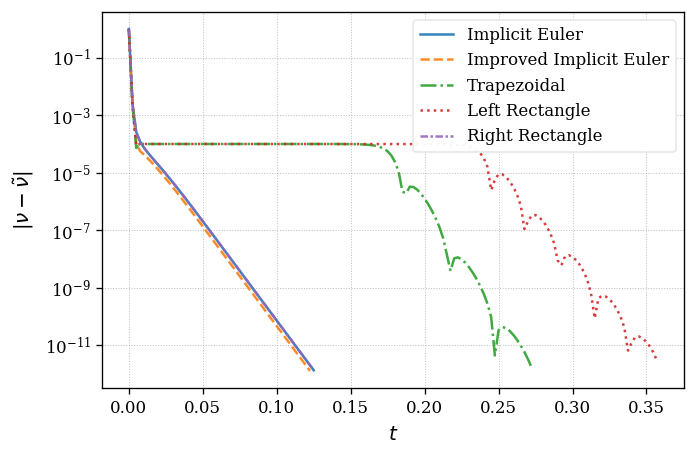

In [6]:
# Example 1
# 2D Allen-Cahn equation
# ∂ₜu - νΔu + f(u) = 0
# Continuous data assimilation algorithm
# ∂ₜv - νΔv + f(v) = μ(u - v)
# 
# #
import importlib.util
if importlib.util.find_spec("petsc4py") is not None:
    import dolfinx
    if not dolfinx.has_petsc:
        print("This program requires DOLFINx to be compiled with PETSc enabled.")
        exit(0)
else:
    print("This program requires petsc4py.")
    exit(0)

try:
    from petsc4py import PETSc
    import dolfinx
    if not dolfinx.has_petsc:
        print("This program requires DOLFINx to be compiled with PETSc enabled.")
        exit(0)
except ModuleNotFoundError:
    print("This program requires petsc4py.")
    exit(0)

from mpi4py import MPI
from numpy import sqrt, linspace, isclose, where, zeros, zeros_like
from dolfinx.mesh import create_unit_square, exterior_facet_indices, CellType
from dolfinx.fem import (
    functionspace, Function, assemble_scalar, Constant,
    form, locate_dofs_topological, dirichletbc
)
from dolfinx.fem.petsc import (
    assemble_matrix, assemble_vector, create_matrix, create_vector, apply_lifting, set_bc
)
from ufl import TestFunction, TrialFunction, inner, grad, dx
import matplotlib.pyplot as plt

# --- Parameters ---
Nx, Ny = 16, 16                # Spatial step
T   = 1.0                      # Total time
ν   = 1e-4                     # Diffusion coefficient
M   = 400                     # Number of time steps
t   = linspace(0, T, M + 1)    # Time points
Δt  = (T / M)
TOL = 1e-8                     # Tolerance

def f(u):
    return u * (u**2 - 1)

def df(u):
    return 3 * u**2 - 1

def L2(u):
    return sqrt(assemble_scalar(form(inner(u, u) * dx)))

# --- Dicrichlet boundary condition ---
def walls_boundary(x):
    return (
        isclose(x[0], 0.0) | isclose(x[0], 1.0) |
        isclose(x[1], 0.0) | isclose(x[1], 1.0)
    )

def initial_condition(x):
    cx, cy, r = 0.5, 0.5, 0.05
    condition = (x[0] - cx)**2 + (x[1] - cy)**2 <= r**2
    return where(condition, 1.0, 0.0)

# --- Mesh ---
domain = create_unit_square(MPI.COMM_WORLD, Nx, Ny, CellType.triangle)
domain.topology.create_connectivity(domain.topology.dim - 1, domain.topology.dim)

# --- Finite element space
V = functionspace(domain, ("Lagrange", 1))

walls = Function(V)
walls.interpolate(lambda x: zeros_like(x[0]))
walls_facets = exterior_facet_indices(domain.topology)
walls_dofs   = locate_dofs_topological(V, domain.topology.dim - 1, walls_facets)
bc_walls     = dirichletbc(walls, walls_dofs)
bcs = [bc_walls]

# --- Variational form ---
w  = TestFunction(V)
δu = TrialFunction(V)
δv = TrialFunction(V)

# --- Reference solution ---
u = zeros((M + 1, len(V.tabulate_dof_coordinates()[:, 0])))
uh = Function(V)
u_ = Function(V)
uh.interpolate(initial_condition)
u[0] = uh.x.array[:]

# --- Time loop ---
for j in range(M):
    u_.x.array[:] = u[j]
    du = Function(V)
    while True:
        # Variational form
        F = form((
            inner(uh - u_, w) * dx
            + Δt * ν * inner(grad(uh), grad(w)) * dx
            + Δt * inner(f(uh), w) * dx
        ))
        J = form((
            inner(δu, w) * dx
            + Δt * ν * inner(grad(δu), grad(w)) * dx
            + Δt * inner(df(uh) * δu, w) * dx
        ))
        # Assemble Jacobian and residual
        A = create_matrix(J)
        b = create_vector(F)

        with b.localForm() as loc_b:
            loc_b.set(0)
        A.zeroEntries()
        assemble_matrix(A, J, bcs = bcs)
        A.assemble()
        assemble_vector(b, F)
        b.ghostUpdate(addv = PETSc.InsertMode.ADD, mode = PETSc.ScatterMode.REVERSE)
        b.scale(-1)
        
        # Compute BC
        apply_lifting(b, [J], [bcs], x0 = [uh.x.petsc_vec], alpha = 1)
        # Set
        set_bc(b, bcs, uh.x.petsc_vec, 1.0)
        b.ghostUpdate(addv = PETSc.InsertMode.INSERT_VALUES, mode = PETSc.ScatterMode.FORWARD)
        
        solver = PETSc.KSP().create(domain.comm)
        solver.setOperators(A)
        solver.setType("preonly")
        solver.getPC().setType("lu")
        solver.getPC().setFactorSolverType("mumps")
        solver.setFromOptions()

        # Solver linear  problem
        solver.solve(b, du.x.petsc_vec)
        du.x.scatter_forward()

        # Update solution
        uh.x.array[:] += du.x.array
        if du.x.petsc_vec.norm(0) < TOL:
            break
    
    # Update reference solution
    u[j + 1] = uh.x.array[:]

# --- Data assimialtion parameter
μ = 200.0
L = 5
χ = zeros((M + 1, L))
stop = zeros(L)
Error = zeros((M + 1, L))
ϵ = 1e-12

def algorithm(ξ, uh, up, vh, vp, l):
    if l == 0:
        # Implicit Euler Method
        den = L2((uh - up) / Δt + f(uh))
        num = L2((vh - vp) / Δt + f(vh) + μ * (vh - uh))
        return ξ * den / num
    elif l == 1:
        # Improved Implicit Euler Method
        den = L2((uh - up) / Δt + f(vh))
        num = L2((vh - vp) / Δt + f(vh) + μ * (vh - uh))
        return ξ * den / num
    elif l == 2:
        # Trapezoidal Method
        den = L2((uh - up) + 0.5 * Δt * (f(uh) + f(up)))
        num = L2((vh - vp) + 0.5 * Δt * (f(vh) + f(vp)) + 0.5 * Δt * μ * ((vh - uh) + (vp - up)))
        return ξ * den / num
    elif l == 3:
        # Left rectangle Method
        den = L2((uh - up) + Δt * f(up))
        num = L2((vh - vp) + Δt * f(vp) + Δt * μ * (vp - up))
        return ξ * den / num
    elif l == 4:
        # Right rectangle Method
        den = L2((uh - up) + Δt * f(uh))
        num = L2((vh - vp) + Δt * f(vh) + Δt * μ * (vh - uh))
        return ξ * den / num

for l in range(L):
    χ[0, l]     = 1.0
    Error[0, l] = abs(ν - χ[0, l])

    vh = Function(V)
    v_ = Function(V)
    vh.interpolate(lambda x: zeros_like(x[0]))
    v_.x.array[:] = vh.x.array

    ξ = Constant(domain, PETSc.ScalarType(1.0))
    for j in range(M):
        ξ.value = χ[j, l]

        v_.x.array[:] = vh.x.array
        dv = Function(V)
        uh.x.array[:] = u[j + 1]
        u_.x.array[:] = u[j]

        while True:
            # Variational form
            F = form((
                inner(vh - v_, w) * dx
                + Δt * ξ * inner(grad(vh), grad(w)) * dx
                + Δt * inner(f(vh), w) * dx
                + Δt * μ * inner(vh - uh, w) * dx
            ))
            J = form((
                inner(δv, w) * dx
                + Δt * ξ * inner(grad(δv), grad(w)) * dx
                + Δt * inner(df(vh) * δv, w) * dx
                + Δt * μ * inner(δv, w) * dx
            ))
            # Assemble Jacobian and residual
            A = create_matrix(J)
            b = create_vector(F)

            with b.localForm() as loc_b:
                loc_b.set(0)
            A.zeroEntries()
            assemble_matrix(A, J, bcs = bcs)
            A.assemble()
            assemble_vector(b, F)
            b.ghostUpdate(addv = PETSc.InsertMode.ADD, mode = PETSc.ScatterMode.REVERSE)
            b.scale(-1)
        
            # Compute BC
            apply_lifting(b, [J], [bcs], x0 = [vh.x.petsc_vec], alpha = 1)
            # Set
            set_bc(b, bcs, vh.x.petsc_vec, 1.0)
            b.ghostUpdate(addv = PETSc.InsertMode.INSERT_VALUES, mode = PETSc.ScatterMode.FORWARD)
        
            solver = PETSc.KSP().create(domain.comm)
            solver.setOperators(A)
            solver.setType("preonly")
            solver.getPC().setType("lu")
            solver.getPC().setFactorSolverType("mumps")
            solver.setFromOptions()

            # Solver linear  problem
            solver.solve(b, dv.x.petsc_vec)
            dv.x.scatter_forward()

            # Update solution
            vh.x.array[:] += dv.x.array
            if dv.x.petsc_vec.norm(0) < TOL:
                break
    
        # Recovery parameter
        χ[j + 1, l] = algorithm(χ[j, l], uh, u_, vh, v_, l)
        Error[j + 1, l] = abs(ν - χ[j + 1, l])
        if Error[j + 1, l] < ϵ:
            stop[l] = j + 1
            break


if domain.comm.rank == 0:
    # Set Latex font with better parameters
    # plt.rc("text"  , usetex    = True)
    # plt.rc("font"  , family    = "serif", size = 12)
    plt.rc("text"  , usetex    = False)
    plt.rc("font"  , family    = "serif", size = 12)
    plt.rc("axes"  , titlesize = 12)        # fontsize of the axes title
    plt.rc("axes"  , labelsize = 12)        # fontsize of the x and y labels
    plt.rc("xtick" , labelsize = 10)        # fontsize of the tick labels
    plt.rc("ytick" , labelsize = 10)        # fontsize of the tick labels
    plt.rc("legend", fontsize  = 10)        # legend fontsize

    # Create figure with better proportions
    fig, ax = plt.subplots(figsize = (6, 4), dpi = 120)
    
    colors = [
        '#1f77b4',  # Matplotlib blue
        '#ff7f0e',  # Orange
        '#2ca02c',  # Green
        '#d62728',  # Red
        '#9467bd'   # Purple
    ]
    
    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]  # Different line styles
    
    labels = [
        r"Implicit Euler",
        r"Improved Implicit Euler",
        r"Trapezoidal",
        r"Left Rectangle",
        r"Right Rectangle"
    ]
    # Plot all five algorithms
    for l in range(L):
        ax.plot(t[0 : int(stop[l])], Error[0 : int(stop[l]), l], color = colors[l], linestyle = linestyles[l],
                linewidth = 1.5, alpha = 0.9, label = labels[l])
    
    # Set scales and labels
    ax.set_yscale("log")
    # ax.set_xlim(0, 1)
    ax.set_xlabel(r"$t$", labelpad = 5)
    ax.set_ylabel(r"$|\nu - \tilde{\nu}|$", labelpad = 5)
    
    # Improved legend
    ax.legend(loc = "best", frameon = True, framealpha = 0.95,
              edgecolor = "0.9", facecolor = "white")
    
    # Grid and layout improvements
    ax.grid(True, which = "both", linestyle = ":", linewidth = 0.6, alpha = 0.5, color = "gray")
    ax.set_axisbelow(True)              # grid behind plot elements
    
    # Adjust layout and save/show
    fig.tight_layout(pad = 1.2)         # extra padding around plot
    
    # For saving
    plt.savefig("./image/Example1_Stop_time.eps", bbox_inches = "tight", dpi = 300)
    plt.savefig("./image/Example1_Stop_time.png", bbox_inches = "tight", dpi = 300)

In [ ]:
# Example 2
# 2D Cahn-Hilliard equation
# ∂u = Δξ
#  ξ = νΔu + f(u)
#  0 = ∇u ⋅ n
#  0 = ∇ϕ ⋅ n
# Continuous data assimilation algorithm
# ∂v = Δη + μ(u - v)
#  η = νΔv + f(v)
#  0 = ∇v ⋅ n
#  0 = ∇η ⋅ n
# 
# #

import importlib.util
if importlib.util.find_spec("petsc4py") is not None:
    import dolfinx
    if not dolfinx.has_petsc:
        print("This program requires DOLFINx to be compiled with PETSc enabled.")
        exit(0)
else:
    print("This program requires petsc4py.")
    exit(0)

try:
    from petsc4py import PETSc
    import dolfinx
    if not dolfinx.has_petsc:
        print("This program requires DOLFINx to be compiled with PETSc enabled.")
        exit(0)
except ModuleNotFoundError:
    print("This program requires petsc4py.")
    exit(0)

from mpi4py import MPI
from numpy import sqrt, linspace, where, zeros, random, argmin, zeros_like
from dolfinx.mesh import create_unit_square, exterior_facet_indices, CellType
from dolfinx.fem import (
    functionspace, Function, assemble_scalar,
    form, locate_dofs_topological, dirichletbc
)
from dolfinx.fem.petsc import assemble_matrix_block, assemble_vector_block
from ufl import (
    TestFunctions, TrialFunctions, MixedFunctionSpace,
    inner, grad, dx,
    extract_blocks
)
import matplotlib.pyplot as plt

# --- Parameters ---
Nx, Ny = 32, 32                # Spatial step
T   = 1.0                      # Total time
ν   = 1e-2                     # Diffusion coefficient
M   = 400                      # Number of time steps
t   = linspace(0, T, M + 1)    # Time points
Δt  = (T / M)
TOL = 1e-8                     # Tolerance

def f(u):
    return u * (u**2 - 1)

def df(u):
    return 3 * u**2 - 1

def L2(u):
    return sqrt(assemble_scalar(form(inner(u, u) * dx)))

# --- Data assimialtion & nudging parameter
μ = 200.0
L = 2                    # number of Algorithm
χ = zeros((M + 1, L))

def initial_condition(x):
    if MPI.COMM_WORLD.rank == 0:
        rng = random.default_rng()
        num_circles = rng.integers(3, 8)
        centers = rng.random((num_circles, 2))
        radii = 0.05 + 0.05 * rng.random(num_circles)

        values = zeros(x.shape[1])
        for i in range(x.shape[1]):
            dists = sqrt((x[0, i] - centers[:, 0])**2 + (x[1, i] - centers[:, 1])**2)
            min_dist = min(dists)
            nearest_radius = radii[argmin(dists)]

            if min_dist < nearest_radius:
                values[i] = 1.0
            else:
                values[i] = 0.0
        return values
    else:
        return zeros(x.shape[1])

# --- Mesh ---
domain = create_unit_square(MPI.COMM_WORLD, Nx, Ny, CellType.triangle)
domain.topology.create_connectivity(domain.topology.dim - 1, domain.topology.dim)

# --- Finite element space
V = functionspace(domain, ("Lagrange", 1))
X = MixedFunctionSpace(V, V)

δu, δξ = TrialFunctions(X)
w , χ  = TestFunctions(X)
# --- Reference solution ---
u = zeros((M + 1, len(V.tabulate_dof_coordinates()[:, 0])))

u_ = Function(V)
ξ_ = Function(V)
uh = Function(V)
uh.interpolate(initial_condition)
ξ_.interpolate(lambda x: zeros_like(x[0]))

u[0] = uh.x.array[:]

# --- Time loop ---
offset = V.dofmap.index_map.size_local * V.dofmap.index_map_bs
du = Function(V)
for j in range(M):
    u_.x.array[:] = u[j]
    i = 0
    while True:
        # Variational form
        F = form(extract_blocks((
            inner(uh - u_, w) * dx
            + Δt * inner(grad(ξ_), grad(w)) * dx
            + inner(ξ_, χ) * dx
            + ν * inner(grad(uh), grad(χ)) * dx
            - inner(f(uh), χ) * dx
        )))
        J = form(extract_blocks((
            inner(δu, w) * dx
            + Δt * inner(grad(δξ), grad(w)) * dx
            + inner(δξ, χ) * dx
            + ν * inner(grad(δu), grad(χ)) * dx
            - inner(df(uh) * δu, χ) * dx
        )))
        A = assemble_matrix_block(J)
        A.assemble()
        b = assemble_vector_block(F, J)
        x = A.createVecRight()

        solver = PETSc.KSP().create(domain.comm)
        solver.setOperators(A)
        solver.setType("preonly")
        solver.getPC().setType("lu")
        solver.getPC().setFactorSolverType("mumps")
        solver.setFromOptions()

        # Solver linear problem
        solver.solve(b, x)

        # Update solution
        uh.x.array[:offset] -= x[:offset]
        du.x.array[:offset] = x[:offset]
        if L2(du) < TOL:
            break
    
    u[j + 1] = uh.x.array[:]

if domain.comm.rank == 0:
    coods = domain.geometry.x[:, :2]

    # Plot solution t = T
    plt.figure(figsize = (4, 4))
    plt.tripcolor(coods[:, 0], coods[:, 1], u[M], shading = "gouraud", cmap = "plasma")
    plt.axis("off")
    plt.grid(True, which = "both", ls = "--")
    plt.tight_layout()
    plt.show()